In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import utils
from BayesModel import BFC, FC

import cProfile
import pstats
device = torch.device('cpu')

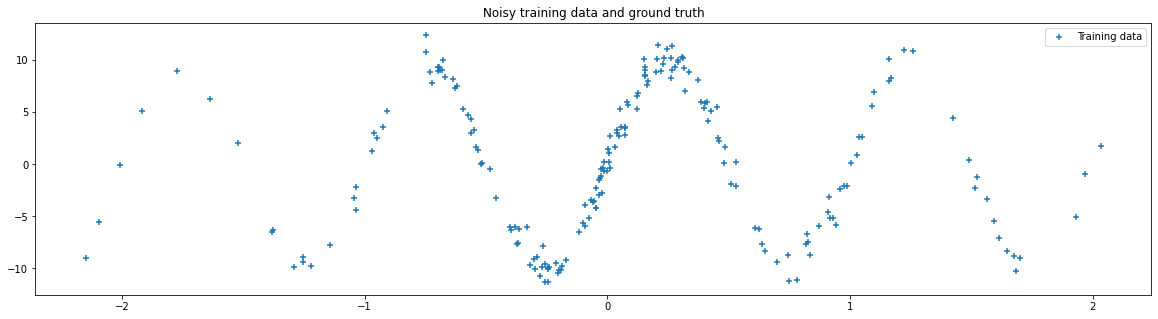

In [111]:
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 200
noise = 1.0

X1 = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
X2 = np.random.uniform(-5,5, train_size).reshape(-1, 1)
# np.random.shuffle(X)
y = f(X1*X2, sigma=noise)
y_true = f(X1*X2, sigma=0.0)

plt.scatter(X1*X2, y, marker='+', label='Training data')
# plt.plot(X1*X2, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend()

In [75]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test, enums=10, single=False):
    Y_sample = Y_test.detach().numpy()

    # sample test data enums times and average to make a prediction
    Y_pred = torch.zeros(enums, *Y_test.size())
    for j in range(enums):
        Y_pred[j] = model(X_test)

    if single:  # Plots all the predictions of a single data point
        y1 = Y_pred.detach().numpy()[:, 1]
        Y = Y_sample[1]
        pred_mean = y1.mean()
        x = np.linspace(0, 1, len(y1))
        plt.plot(x, y1, "bo", label="all preds for single datapoint")
        plt.plot(x, np.ones_like(x) * Y_sample[1], "r--", lw=5, label="true value")
        plt.plot(x, np.ones_like(x) * pred_mean, "k--", lw=4, label="prediction mean")
        plt.plot(x, pred_mean + np.ones_like(x) * y1.std(), "g--", lw=4, label="prediction std")
        plt.plot(x, pred_mean - np.ones_like(x) * y1.std(), "g--", lw=4)
        plt.xlabel("Prediction count")
        plt.ylabel("Value")
        plt.title("All predictions for a single datapoint after training")
    else:  # Plot mean of all predictions for 40 datapoints, with error bounds
        y1 = Y_pred.detach().numpy()
        pred_mean = y1.mean(0) 
        pred_std = y1.std(0)
        print("mean mean: ", pred_mean.mean())
        print("mean std:", pred_mean.std())
        print("std mean: ", pred_std.mean())
        print("std std:", pred_std.std())
        x = np.arange(len(Y_sample))
        xx = np.c_[x, x, x, x, x, x] if Y_test.size(1) == 3 else np.c_[x, x]
        interval = np.c_[pred_mean - pred_std, pred_mean + pred_std]
        R2 = 1 - ((Y_sample - pred_mean) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    
        plt.plot(Y_sample[:40], "bo", ms=8, label="target")
        plt.plot(pred_mean[:40], "ro", ms=4, label="mean")
        plt.plot(xx[:40], interval[:40], "go", ms=4, label="1 sigma")
        plt.title(f"R2: {R2}")
        plt.xlabel("Datapoints")
        plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_model_pred_freq(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()
    Y_pred_sample = model(X_test.to(torch.float)).detach().numpy()

    R2 = 1 - ((Y_sample - Y_pred_sample) ** 2).sum() / ((Y_sample - Y_sample.mean()) ** 2).sum()
    plt.plot(Y_sample[:100], "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample[:100], "ro--", ms=4, label="prediction")
    plt.title(f"R2-score on test data: {R2}")
    plt.legend()
    plt.show()

In [152]:
def train_model(*, model, optimer, x, y, device, epochs, enums=10):
    pbar = tqdm(range(epochs))
    losses = {"total": [], "recon": [], "kl": []}
    loc_grads = {"absmean_0": [], "absmean_2": [], "absmean_4": [], "std_0": [], "std_2": [], "std_4": []}
    rho_grads = {"absmean_0": [], "absmean_2": [], "absmean_4": [], "std_0": [], "std_2": [], "std_4": []}
    grads = {"loc": loc_grads, "rho": rho_grads}
    for epoch in pbar:
        optimer.zero_grad()
            # sample batch enums times during training and average prediction before calculating loss
        outs = torch.zeros(enums, *y.size())
        for j in range(enums):
            outs[j] = model(x, train=True)
        
        pred = outs.mean(0)  # take average of all predictions of each datapoint as final prediction of that datapoint 
        # loss_kl = model.kl_reset() / (len(x) * enums)  # normalise by number of batches and enums
        loss_recon = -torch.distributions.Normal(pred, 0.1).log_prob(y).mean()

        # loss =  loss_recon + loss_kl
        loss = loss_recon
        loss.backward()

        optimer.step()
        for layer in [0, 2, 4]:
            grads["loc"][f"absmean_{layer}"].append(model.layers[layer].weight_loc.grad.abs().mean())
            grads["loc"][f"std_{layer}"].append(model.layers[layer].weight_loc.grad.std())
            grads["rho"][f"absmean_{layer}"].append(model.layers[layer].weight_rho.grad.abs().mean())
            grads["rho"][f"std_{layer}"].append(model.layers[layer].weight_rho.grad.std())
            
        # pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}, kl_loss: {loss_kl:.4f}")
        pbar.set_description(f"total loss: {loss:.4f}, recon. loss: {loss_recon:.4f}")
        losses["total"].append(loss.detach().numpy())
        losses["recon"].append(loss_recon.detach().numpy())
        # losses["kl"].append(loss_kl.detach().numpy())


    return losses, grads

In [153]:
X = np.concatenate((X1, X2), axis=1)
X = torch.tensor(X)
# X = X.type(torch.long)
# print(X.dtype)
# y = torch.tensor(y)
# print(y.dtype)

In [157]:
X = torch.tensor(X)
y = torch.tensor(y)
# net = BFC(features=1, classes=1, hiddens=[20, 20], prior={"dist": "vmf", "loc": 0, "scale": .11, "record": True, "dist_kwargs": {"k": 1}})
net = BFC(features=2, classes=1, hiddens=[30, 30], prior={"dist": "normal", "loc": 0, "scale": .1, "record": True})
optimizer = torch.optim.AdamW(net.parameters(), lr=0.1)

C:\Users\Khachatur\AppData\Local\Temp\ipykernel_100472\403609520.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
C:\Users\Khachatur\AppData\Local\Temp\ipykernel_100472\403609520.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


  0%|          | 0/1500 [00:00<?, ?it/s]

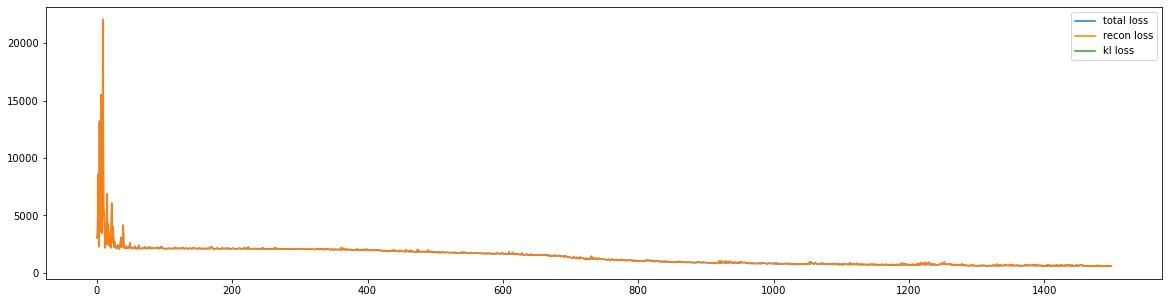

In [158]:
profiler = cProfile.Profile()
profiler.enable()
losses, grads = train_model(model=net, optimer=optimizer, x=X, y=y, device=device, epochs=1500, enums=10)
profiler.disable()

plt.plot(losses["total"][0:], label="total loss")
plt.plot(losses["recon"][0:], label="recon loss")
plt.plot(losses["kl"][0:], label="kl loss")
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

500
200
[[-7.45714862e-01]
 [-1.37804843e+00]
 [ 2.34549138e-01]
 [ 9.17250219e-01]
 [-2.97908362e-01]
 [ 5.29678268e-01]
 [-5.15568616e-01]
 [-2.75708912e-01]
 [ 6.26142943e-01]
 [-1.91618431e+00]
 [-7.30982470e-01]
 [-1.03700106e+00]
 [ 9.74521827e-01]
 [-1.03508165e+00]
 [-2.14799232e+00]
 [ 2.03294770e+00]
 [-2.09411273e+00]
 [-1.77205888e+00]
 [-6.19156533e-01]
 [ 1.17092819e+00]
 [-6.81048059e-01]
 [-9.47504285e-01]
 [ 4.80414458e-01]
 [-5.63457132e-01]
 [ 1.00356103e+00]
 [ 1.61346355e+00]
 [ 4.71288275e-02]
 [ 1.02850565e+00]
 [-6.27504892e-01]
 [-2.43042268e-01]
 [-1.04495017e+00]
 [-1.38105429e+00]
 [ 1.51587641e+00]
 [-1.28940443e+00]
 [-3.31143508e-01]
 [-1.52042261e+00]
 [ 1.26645171e-01]
 [ 1.54422942e-01]
 [-2.89051293e-01]
 [-9.71237322e-01]
 [-3.24072951e-02]
 [-3.69501600e-01]
 [-6.34884144e-01]
 [-1.25568678e+00]
 [ 9.32084349e-01]
 [ 7.47910231e-01]
 [ 2.03050446e-01]
 [-5.41305755e-01]
 [ 9.88066528e-01]
 [ 9.59597713e-01]
 [ 1.04851391e+00]
 [ 1.03793621e+00]
 [-9

ValueError: x and y can be no greater than 2D, but have shapes (200, 1, 1) and (200, 1)

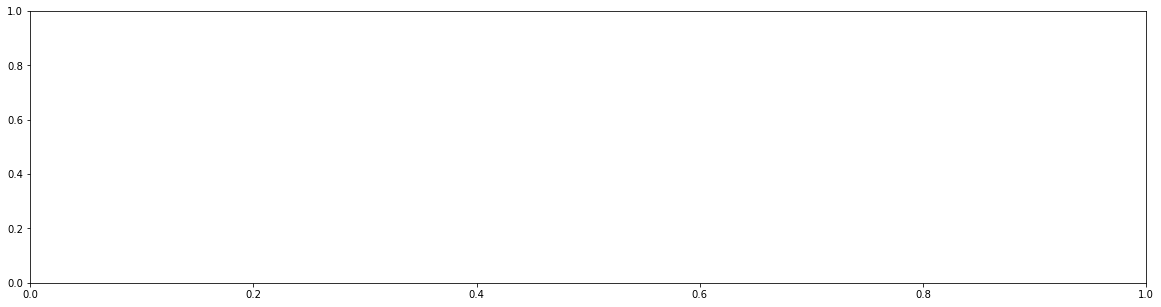

In [165]:
Xt1 = np.linspace(-0.7, 0.7, train_size).reshape(-1, 1)
Xt2 = np.random.uniform(-5,5, train_size).reshape(-1, 1)
X_test = np.concatenate((Xt1, Xt2), axis=1)
# X_test = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
X_test = torch.tensor(X_test)
y_pred_list = []

for i in tqdm(range(500)):
    y_pred = net(X_test).detach().numpy()
    y_pred_list.append(y_pred)

print(len(y_pred_list))
print(len(y_pred_list[0]))
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)


plt.plot(Xt1*Xt2, y_mean, 'r+', label='Predictive mean')
plt.scatter(X1*X2, y, marker='+', label='Training data')
plt.fill_between((Xt1*Xt2).ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend()